# Covid-19 Chest X-Ray Prediction
Welcome to the Covid-19 classification dataset where we will be taking X-Ray images of chests that have either covid-19, pneumonia or neither. We will be using the ResNet50 classifier because the number of data samples that we are given is only a few hundred, which means that we need a transfer learning model. Predicting this dataset is important as it could help doctors in understanding whether or not someone has the coronavirus.

### If you enjoy this notebook and find it helpful, please give it an upvote as it will help me more of these.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import cv2
import glob
import torch
import shutil
import itertools
import torch.nn as nn
import torch.optim as optim
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from pathlib import Path
from torch.nn import functional as F
from torchvision import datasets, models, transforms
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Visualisation
The visualisations that we'll make are three sets of the covid, pneumonia and normal chest x-ray images.

In [3]:
base_path = '/content/drive/MyDrive/FastCampus/COVID-19_Radiography_Dataset'
covid_path = f'{base_path}/COVID'
normal_path = f'{base_path}/NORMAL'
pneumonia_path = f'{base_path}/Viral Pneumonia'

In [18]:
images = [f'{base_path}/COVID/images/COVID-1.png',
        f'{base_path}/Normal/images/Normal-1.png',
        f'{base_path}/Viral Pneumonia/images/Viral Pneumonia-1.png',
        f'{base_path}/COVID/images/COVID-2.png',
        f'{base_path}/Normal/images/Normal-2.png',
        f'{base_path}/Viral Pneumonia/images/Viral Pneumonia-2.png',
        f'{base_path}/COVID/images/COVID-3.png',
        f'{base_path}/Normal/images/Normal-3.png',
        f'{base_path}/Viral Pneumonia/images/Viral Pneumonia-3.png']

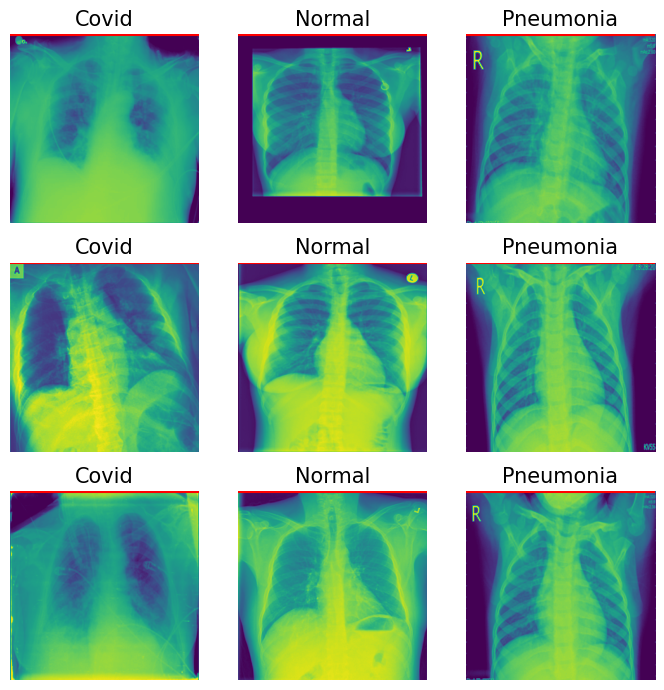

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
labels = ['Covid', 'Normal', 'Pneumonia']
i = 0
j = 0

for row in axes:
    for plot in row:
        plot.imshow(cv2.imread(images[j], 0))
        plot.axhline(y=0.5, color='r')
        plot.set_title(labels[i], fontsize=15)
        plot.axis('off')
        i += 1
        j += 1
    i = 0

fig.tight_layout()
plt.show()

## Sorting out the files
In order for our transfer learning model to work, we will first need to move the images into new folders. We will organise them split up into train and test sets, and then split it even further into the types of classes we have.

The structure of the files will be as follows:

1.  train
    * covid
    * pneumonia
    * normal
2.  test
    * covid
    * pneumonia
    * normal

In [20]:
covid_path = f'{base_path}/COVID/images'
normal_path = f'{base_path}/Normal/images'
pneumonia_path = f'{base_path}/Viral Pneumonia/images'

In [21]:
try:
    os.mkdir('./train')
    os.mkdir('./test')

    os.mkdir('./train/covid')
    os.mkdir('./test/covid')

    os.mkdir('./train/normal')
    os.mkdir('./test/normal')

    os.mkdir('./train/pneumonia')
    os.mkdir('./test/pneumonia')
except:
    pass

In the following cell of code, we gather the length of how long each training set should be for each class.

In [22]:
covid_train_len = int(np.floor(len(os.listdir(covid_path))*0.8))
covid_len = len(os.listdir(covid_path))

normal_train_len = int(np.floor(len(os.listdir(normal_path))*0.8))
normal_len = len(os.listdir(normal_path))

pneumonia_train_len = int(np.floor(len(os.listdir(pneumonia_path))*0.8))
pneumonia_len = len(os.listdir(pneumonia_path))

Then, we loop over each class and split them each up into train and test sets.

In [23]:
for trainimg in itertools.islice(glob.iglob(os.path.join(covid_path, '*.png')), covid_train_len):
    shutil.copy(trainimg, './train/covid')

for trainimg in itertools.islice(glob.iglob(os.path.join(normal_path, '*.png')), normal_train_len):
    shutil.copy(trainimg, './train/normal')

for trainimg in itertools.islice(glob.iglob(os.path.join(pneumonia_path, '*.png')), pneumonia_train_len):
    shutil.copy(trainimg, './train/pneumonia')


for testimg in itertools.islice(glob.iglob(os.path.join(covid_path, '*.png')), covid_train_len, covid_len):
    shutil.copy(testimg, './test/covid')

for testimg in itertools.islice(glob.iglob(os.path.join(normal_path, '*.png')), normal_train_len, normal_len):
    shutil.copy(testimg, './test/normal')

for testimg in itertools.islice(glob.iglob(os.path.join(pneumonia_path, '*.png')), pneumonia_train_len, pneumonia_len):
    shutil.copy(testimg, './test/pneumonia')

## Transforming our data
Now the transfer learning begins. We must firstly transform each dataset to have certain changes in it. For the train set, we resize the images, flip them horizontally and vertically and change their colours, while for the test set, we only resize the images.

In [24]:
normalizer = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((244, 244)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        normalizer
    ]),

    'validation': transforms.Compose([
        transforms.Resize((244, 244)),
        transforms.ToTensor(),
        normalizer
    ])
}

Next, we use those transforms that we created and apply them to our data, storing it in a new file location.

In [25]:
from PIL import Image

class CustomDataset():
    def __init__(self,data_dir, transform):
        self.class_map = {"normal" : 0, "pneumonia": 1, "covid":2}
        image_path = glob.glob(data_dir+'/*/*.png')
        cls_name = [self.class_map[i.split('/')[-2]] for i in image_path]

        print(image_path)
        self.data = np.stack([image_path,cls_name], axis=-1)
        self.transform = transform
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_id = self.data[idx]
        img = cv2.imread(img_path)
        img = Image.fromarray(img)
        img_tensor = self.transform(img)
        class_id = torch.tensor([int(class_id)])
        return img_tensor, class_id

In [60]:
ls ./train

covid/  normal/  pneumonia/


In [26]:
data_images = {
    'train': datasets.ImageFolder('./train', data_transforms['train']),
    'validation': datasets.ImageFolder('./test', data_transforms['validation'])
}

In [62]:
data_images['train'][0]

(tensor([[[ 0.0549, -0.7137, -0.6667,  ..., -2.0000, -1.6078, -0.0706],
          [-0.6196, -0.9020, -0.7451,  ..., -2.0000, -1.8118, -1.1843],
          [-0.9176, -1.0275, -0.8392,  ..., -1.9686, -1.8902, -1.7647],
          ...,
          [-1.9373, -1.9843, -2.0000,  ..., -1.9843, -1.9373, -1.7804],
          [-1.3569, -1.9059, -2.0000,  ..., -1.9843, -1.9373, -1.6078],
          [ 0.0392, -1.6706, -2.0000,  ..., -1.9843, -1.7961, -0.6039]],
 
         [[ 0.0549, -0.7137, -0.6667,  ..., -2.0000, -1.6078, -0.0706],
          [-0.6196, -0.9020, -0.7451,  ..., -2.0000, -1.8118, -1.1843],
          [-0.9176, -1.0275, -0.8392,  ..., -1.9686, -1.8902, -1.7647],
          ...,
          [-1.9373, -1.9843, -2.0000,  ..., -1.9843, -1.9373, -1.7804],
          [-1.3569, -1.9059, -2.0000,  ..., -1.9843, -1.9373, -1.6078],
          [ 0.0392, -1.6706, -2.0000,  ..., -1.9843, -1.7961, -0.6039]],
 
         [[ 0.0549, -0.7137, -0.6667,  ..., -2.0000, -1.6078, -0.0706],
          [-0.6196, -0.9020,

In [27]:
dataloaders = {
    'train': torch.utils.data.DataLoader(data_images['train'], batch_size=32, shuffle=True, num_workers=0),
    'validation': torch.utils.data.DataLoader(data_images['validation'], batch_size=32,shuffle=True,num_workers=0)
}

# Creating a ResNet50 model

After the data has been transformed, we now create a device which makes the model be able to run on a cpu and cuda core, depending on which you use.

Furthermore, we create a pretrained ResNet50 model.

In [28]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = models.resnet50(pretrained=True).to(device)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 149MB/s]


Also very importantly, we create the criterion of CrossEntropyLoss and an optimizer of Adam.

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

# Training our model

Finally, we train our model. As you can see below, the lines of code are of a great multitude and complexity. The result, however, is a trained model which produces a pleasing accuracy.

In [30]:
def trained_model(model, criterion, optimizer, epochs):
    for epoch in range(epochs):

        print('Epoch:', str(epoch+1) + '/' + str(epochs))
        print('-'*10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train() #this trains the model
            else:
                model.eval() #this evaluates the model

            running_loss, running_corrects = 0.0, 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device) #convert inputs to cpu or cuda
                labels = labels.to(device).squeeze() #convert labels to cpu or cuda

                outputs = model(inputs) #outputs is inputs being fed to the model
                loss = criterion(outputs, labels) #outputs are fed into the model

                if phase == 'train':
                    optimizer.zero_grad() #sets gradients to zero
                    loss.backward() #computes sum of gradients
                    optimizer.step() #preforms an optimization step
                _, preds = torch.max(outputs, 1) #max elements of outputs with output dimension of one
                running_loss += loss.item() * inputs.size(0) #loss multiplied by the first dimension of inputs
                running_corrects += torch.sum(preds == labels.data) #sum of all the correct predictions

            epoch_loss = running_loss / len(data_images[phase]) #this is the epoch loss
            epoch_accuracy = running_corrects.double() / len(data_images[phase]) #this is the epoch accuracy

            print(phase, ' loss:', epoch_loss, 'epoch_accuracy:', epoch_accuracy)

    return model

In [31]:
model = trained_model(model, criterion, optimizer, 3)

Epoch: 1/3
----------
train  loss: 0.2722001844739774 epoch_accuracy: tensor(0.9064, device='cuda:0', dtype=torch.float64)
validation  loss: 0.22107984298257036 epoch_accuracy: tensor(0.9228, device='cuda:0', dtype=torch.float64)
Epoch: 2/3
----------
train  loss: 0.17565583272563534 epoch_accuracy: tensor(0.9425, device='cuda:0', dtype=torch.float64)
validation  loss: 0.18684519226789081 epoch_accuracy: tensor(0.9330, device='cuda:0', dtype=torch.float64)
Epoch: 3/3
----------
train  loss: 0.15935708587147357 epoch_accuracy: tensor(0.9484, device='cuda:0', dtype=torch.float64)
validation  loss: 0.1831020488906514 epoch_accuracy: tensor(0.9343, device='cuda:0', dtype=torch.float64)


In [32]:
torch.save(model.state_dict(), 'resnet50_covid_19.pth')

In [65]:
w.shape

torch.Size([3, 2048])

In [71]:
activation['final'].shape

torch.Size([1, 512, 8, 8])

In [77]:
w[0][:act.size(0)]

tensor([ 3.4295e-02, -3.5552e-02, -8.0041e-03,  4.0895e-03, -1.9098e-02,
        -1.3723e-02,  2.2077e-02,  1.2074e-02, -8.6044e-02, -4.5946e-02,
        -3.7749e-02,  6.9344e-02, -2.1710e-02,  1.4466e-02, -8.1708e-02,
        -3.2224e-02,  3.4449e-02, -7.2936e-03, -3.9034e-02, -1.3107e-02,
         4.2286e-02, -5.6729e-02,  3.4410e-02,  8.5456e-02, -1.4246e-02,
        -2.4850e-02, -3.8610e-02, -1.9655e-02, -7.7739e-02,  3.6734e-02,
        -1.3339e-02,  3.7804e-02, -1.2059e-02, -9.8488e-03, -2.0088e-02,
         2.2439e-02,  2.6513e-02,  3.6317e-02, -1.1923e-02,  3.2399e-02,
         1.0910e-02, -1.0149e-02,  2.2116e-02,  4.6329e-02,  3.5998e-02,
        -6.0845e-02,  3.1380e-03, -2.8053e-02, -5.9845e-02,  6.0934e-02,
         3.0543e-02, -1.1000e-02,  3.9110e-02, -2.5633e-02,  1.7864e-02,
        -2.3681e-03, -1.4089e-02,  2.6636e-02, -5.1664e-03,  5.0309e-03,
         1.8530e-03, -1.7186e-02,  1.6352e-02, -1.2926e-03,  3.0990e-03,
         6.8649e-03,  4.3568e-02, -3.6188e-02,  2.5

In [74]:
output_cls

0

predict_name: covid
gt_name: covid


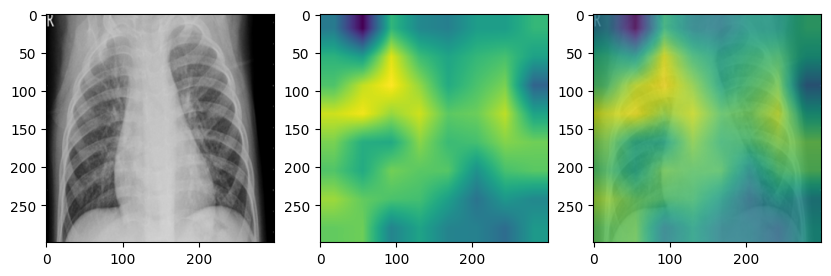

In [90]:
# define hooks to save activation
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

n = 2400
model.eval()
re_class_map = {0:"normal",1: "pneumonia",2: "covid"}
with torch.no_grad():
    from torch.autograd import Variable
    model.layer4[1].bn2.register_forward_hook(get_activation("final"))

    origin_img = cv2.imread(data_images['validation'].imgs[n][0])
    sample, label = data_images['validation'][n]
    tensor_img = sample.permute((1,2,0))

    img_variable = Variable(sample.unsqueeze(0))
    output = model(img_variable.to(device))

    # predict output
    output_cls = torch.argmax(output,axis=1).cpu().numpy()[0]
    predict_name = re_class_map[output_cls]
    gt_name = re_class_map[label]

    print(f'predict_name: {predict_name}')
    print(f'gt_name: {gt_name}')

    # get CAM
    act = activation['final'].squeeze() # activation mask
    w = model.fc.weight  # activation에 weight
    for idx in range(act.size(0)): # CAM 연산 (결국 for loop으로 모든 가중치 합하는 것!!)
        if idx == 0:
            tmp = act[idx] * w[output_cls][idx] # 각 label에 해당하는 가중치
        else:
            tmp += act[idx] * w[output_cls][idx]

    # 모든 이미지 팍셀값을 0~255로 스케일하기
    normalized_cam = tmp.cpu().numpy()
    normalized_cam = (normalized_cam - np.min(normalized_cam)) / (np.max(normalized_cam) - np.min(normalized_cam))
    cam_img = cv2.resize(np.uint8(normalized_cam * 255), dsize=origin_img.shape[:2])

fig,axs = plt.subplots(1,3,figsize=(10,10))
axs[0].imshow(origin_img)

axs[1].imshow(cam_img)

axs[2].imshow(origin_img)
axs[2].imshow(cam_img, alpha=0.8)
#     final_cam = F.interpolate(cam, sample.shape[-2:], mode="bilinear")


#     fc_weights = model.fc[0].weight[[output_cls], :].unsqueeze(2).unsqueeze(3)
#     cam = (fc_weights * activation["layer4"]).sum(1, keepdim=True)

#     # add dimension to make compatible with interpolation
#     cam = cam
#     cam.shape
#     final_cam = F.interpolate(cam, sample.shape[-2:], mode="bilinear")


In [35]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 11.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.0-py3-none-any.whl size=38070 sha256=e78f101a270e31891b06206add6810a649844ceb085424d62552e748deacf1cd
  Stored in directory: /root/.cache/pip/wheels/5b/e5/3d/8548241d5cffe53ad1476c566a61ad9bf09cc61a9430f09726
Successfully built grad-cam


In [82]:
label

0

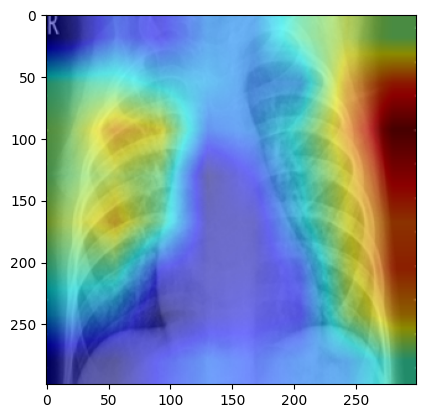

In [92]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

origin_img = cv2.imread(data_images['validation'].imgs[n][0])
input_tensor, label = data_images['validation'][n]
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)
targets = [ClassifierOutputTarget(label)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor.unsqueeze(0), targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
grayscale_cam = cv2.resize(grayscale_cam, dsize=origin_img.shape[:2])
visualization = show_cam_on_image(np.array(origin_img/255).astype(np.float32), grayscale_cam, use_rgb=True)
plt.imshow(visualization)